# Deliverable 3.1 — x-velocity MPC (ωy, β, vx)

This notebook explains and demonstrates the MPC design choices for the x-velocity controller.

## Requirements (from project text)
- Use the discretized linearized *delta* model: Δx = x − xs, Δu = u − us, and apply u = Δu + us.
- Enforce validity constraints: |β| ≤ 10° and servo limits |δ2| ≤ 15°.
- Design a recursively feasible, stabilizing MPC that settles within 7 seconds from vx = 5 m/s.


## 1. Why terminal cost + terminal set?
We follow the stabilizing MPC recipe:

- Stage cost l(x,u) is positive definite.
- Terminal controller κf(x)=Kx (LQR) stabilizes the system.
- Terminal set Xf is invariant under κf and respects constraints.
- Terminal cost Vf(x)=xᵀPx decreases along κf.

These conditions guarantee recursive feasibility and Lyapunov stability of the MPC closed-loop.


In [ ]:
# Imports and paths
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from src.rocket import Rocket
from LinearMPC_template.MPCVelControl import MPCVelControl
from LinearMPC_template.MPCControl_xvel import MPCControl_xvel
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)


## 2. Build linear model, discretize, and create controller
The Rocket class provides trim (xs,us) and linearization matrices (A,B). We reduce to [ωy, β, vx] and input δ2.


In [ ]:
Ts = 1/20
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()
sys = rocket.linearize_sys(xs, us)
A, B = sys.A, sys.B

# Horizon (tune)
H = 4.0

# Instantiate x-velocity MPC
mpc_x = MPCControl_xvel(A=A, B=B, xs=xs, us=us, Ts=Ts, H=H)
print("N=", mpc_x.N)
print("A_d:\n", mpc_x.A)
print("B_d:\n", mpc_x.B)
print("xs_red=", mpc_x.xs)
print("us_red=", mpc_x.us)


N= 160
A_d:
 [[ 1.        -0.        -0.       ]
 [ 0.05       1.         0.       ]
 [ 0.0122575  0.4903     1.       ]]
B_d:
 [[-3.27374224]
 [-0.08184356]
 [ 0.47692403]]
xs_red= [0. 0. 0.]
us_red= [0.]


## 3. Choice of weights (Q,R)
- We penalize β strongly to stay in the linear region (|β| ≤ 10°).
- We penalize vx to achieve the required settling time.
- ωy is penalized moderately to avoid aggressive rotational motion.
- R limits δ2 usage to avoid saturation and keep smooth control.


In [9]:
print("Q=\n", mpc_x.Q)
print("R=\n", mpc_x.R)


Q=
 [[ 0.5  0.   0. ]
 [ 0.  70.   0. ]
 [ 0.   0.  50. ]]
R=
 [[1.]]


## 4. Step response test (vx initial = 5 m/s)
We verify that the controller brings vx to zero within ~7 seconds while respecting constraints.


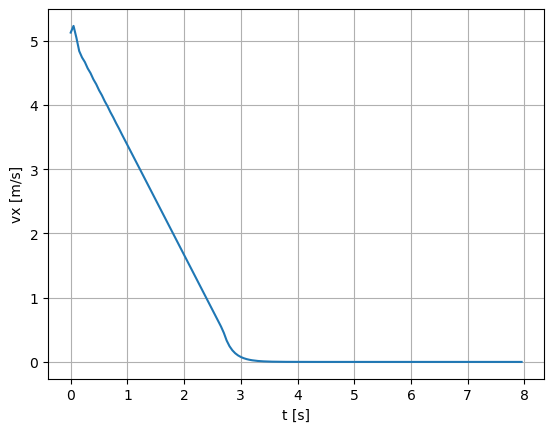

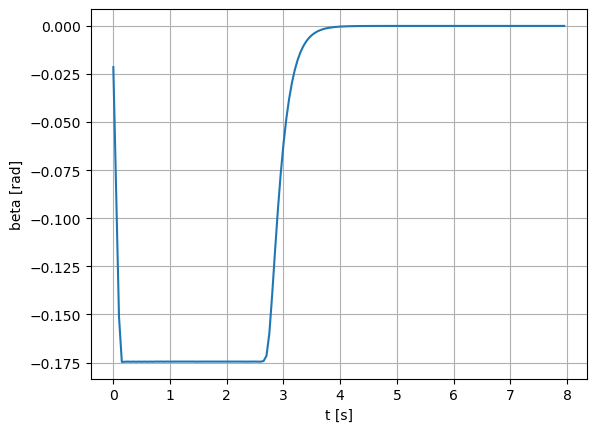

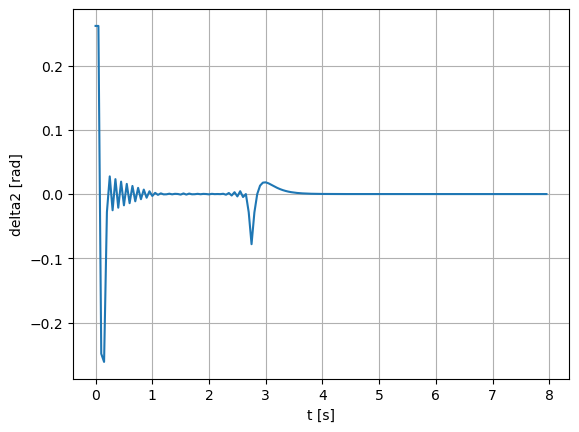

In [10]:
# Build an initial full state x0 with vx=5 m/s
x0 = xs.copy()
x0[6] = 5.0

# Target: vx -> 0 (full state target)
x_target = xs.copy()  # trim (vx=0)

# Closed-loop simulate only the reduced linear model for quick test
Tsim = 8.0
steps = int(Tsim / Ts)

# Discretize full linear model once for simulation
C_dummy = np.zeros((1, A.shape[0]))
D_dummy = np.zeros((1, B.shape[1]))
Ad, Bd, _, _, _ = cont2discrete((A, B, C_dummy, D_dummy), Ts)

vx_hist = []
beta_hist = []
u_hist = []
t_hist = []

x = x0.copy()
for k in range(steps):
    u0_red, xpred_red, upred_red = mpc_x.get_u(x, x_target=x_target)
    # Apply to full input vector
    u = us.copy()
    u[1] = u0_red[0]

    # Step linearized delta dynamics in full space: x_{k+1} = xs + Ad (x-xs) + Bd (u-us)
    dx = x - xs
    du = u - us
    dx_next = Ad @ dx + Bd @ du
    x = xs + dx_next

    t_hist.append(k*Ts)
    vx_hist.append(x[6])
    beta_hist.append(x[4])
    u_hist.append(u[1])

plt.figure()
plt.plot(t_hist, vx_hist)
plt.xlabel('t [s]'); plt.ylabel('vx [m/s]'); plt.grid(True)

plt.figure()
plt.plot(t_hist, beta_hist)
plt.xlabel('t [s]'); plt.ylabel('beta [rad]'); plt.grid(True)

plt.figure()
plt.plot(t_hist, u_hist)
plt.xlabel('t [s]'); plt.ylabel('delta2 [rad]'); plt.grid(True)
plt.grid(True)


## 5. Constraint satisfaction & recursive feasibility
Recursive feasibility is enforced by:
- Hard constraints at every prediction step on β and δ2.
- Terminal constraint Δx_N ∈ Xf where Xf is invariant under LQR u=Kx.

This follows the standard stabilizing MPC construction.


In [2]:
import numpy as np
from scipy.signal import cont2discrete
import matplotlib.pyplot as plt

# ---- Helpers ----
def settling_time(t, y, band):
    """
    First time index i where |y[j]| <= band for all j>=i.
    Returns np.nan if never settles.
    """
    y = np.asarray(y)
    inside = np.abs(y) <= band
    for i in range(len(t)):
        if np.all(inside[i:]):
            return t[i]
    return np.nan


def simulate_full_linear_delta(rocket, mpc_vel, Tsim, x0, x_target=None, u_target=None):
    """
    Full-state linear discrete simulation using delta model.
    Uses mpc_vel.get_u(t0, x0, x_target, u_target) each step.
    """
    Ts = mpc_vel.mpc_x.Ts
    steps = int(np.round(Tsim / Ts))

    xs = mpc_vel.xs
    us = mpc_vel.us

    sys = rocket.linearize_sys(xs, us)
    A, B = sys.A, sys.B

    nx = A.shape[0]; nu = B.shape[1]
    C = np.zeros((1, nx)); D = np.zeros((1, nu))
    Ad, Bd, *_ = cont2discrete((A, B, C, D), Ts)

    t_hist = np.arange(steps + 1) * Ts
    X = np.zeros((12, steps + 1))
    U = np.zeros((4, steps))

    X[:, 0] = x0.copy()
    x = x0.copy()

    if x_target is None:
        x_target = xs.copy()
    if u_target is None:
        u_target = us.copy()

    for k in range(steps):
        u0, *_ = mpc_vel.get_u(t_hist[k], x, x_target=x_target, u_target=u_target)
        U[:, k] = u0

        dx = x - xs
        du = u0 - us
        dx_next = Ad @ dx + Bd @ du
        x = xs + dx_next

        X[:, k + 1] = x

    return t_hist, X, U


def print_metrics(tag, t, X, U, idx_state, ref_value, band):
    y = X[idx_state, :] - ref_value
    ts = settling_time(t, y, band)

    alpha = X[3, :]
    beta  = X[4, :]
    d1 = U[0, :]
    d2 = U[1, :]
    pavg = U[2, :]
    pdiff = U[3, :]

    print(f"=== {tag} ===")
    print(f"Settling time (band={band}): {ts:.3f} s")
    print(f"max |alpha| [deg]: {np.max(np.abs(alpha))*180/np.pi:.2f}")
    print(f"max |beta|  [deg]: {np.max(np.abs(beta))*180/np.pi:.2f}")
    print(f"max |delta1| [deg]: {np.max(np.abs(d1))*180/np.pi:.2f}")
    print(f"max |delta2| [deg]: {np.max(np.abs(d2))*180/np.pi:.2f}")
    print(f"Pavg min/max: {np.min(pavg):.2f} / {np.max(pavg):.2f}")
    print(f"max |Pdiff|: {np.max(np.abs(pdiff)):.2f}")


# ---- Build rocket + controller ----
Ts = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)

H = 4.0
mpc = MPCVelControl().new_controller(rocket, Ts, H)

# ---- Test settings ----
Tsim = 8.0  # must be >= 7s requirement
xs, us = mpc.xs, mpc.us

# 2% bands for settling time checks:
band_v = 0.02 * 5.0             # for 5 m/s step -> 0.1 m/s
band_gamma = 0.02 * (40*np.pi/180)  # for 40deg step

# ---- 1) x-velocity: vx initial = 5 m/s -> 0 ----
x0 = xs.copy(); x0[6] = 5.0
xT = xs.copy()
t, X, U = simulate_full_linear_delta(rocket, mpc, Tsim, x0, x_target=xT, u_target=us)
print_metrics("x-vel test (vx: 5 -> 0)", t, X, U, idx_state=6, ref_value=0.0, band=band_v)

plt.figure(); plt.plot(t, X[6, :]); plt.xlabel('t [s]'); plt.ylabel('vx [m/s]'); plt.grid(True)
plt.figure(); plt.plot(t, X[4, :]); plt.xlabel('t [s]'); plt.ylabel('beta [rad]'); plt.grid(True)
plt.figure(); plt.plot(t[:-1], U[1, :]); plt.xlabel('t [s]'); plt.ylabel('delta2 [rad]'); plt.grid(True)

# ---- 2) y-velocity: vy initial = 5 m/s -> 0 ----
x0 = xs.copy(); x0[7] = 5.0
xT = xs.copy()
t, X, U = simulate_full_linear_delta(rocket, mpc, Tsim, x0, x_target=xT, u_target=us)
print_metrics("y-vel test (vy: 5 -> 0)", t, X, U, idx_state=7, ref_value=0.0, band=band_v)

plt.figure(); plt.plot(t, X[7, :]); plt.xlabel('t [s]'); plt.ylabel('vy [m/s]'); plt.grid(True)
plt.figure(); plt.plot(t, X[3, :]); plt.xlabel('t [s]'); plt.ylabel('alpha [rad]'); plt.grid(True)
plt.figure(); plt.plot(t[:-1], U[0, :]); plt.xlabel('t [s]'); plt.ylabel('delta1 [rad]'); plt.grid(True)

# ---- 3) z-velocity: vz initial = 5 m/s -> 0 ----
x0 = xs.copy(); x0[8] = 5.0
xT = xs.copy()
t, X, U = simulate_full_linear_delta(rocket, mpc, Tsim, x0, x_target=xT, u_target=us)
print_metrics("z-vel test (vz: 5 -> 0)", t, X, U, idx_state=8, ref_value=0.0, band=band_v)

plt.figure(); plt.plot(t, X[8, :]); plt.xlabel('t [s]'); plt.ylabel('vz [m/s]'); plt.grid(True)
plt.figure(); plt.plot(t[:-1], U[2, :]); plt.xlabel('t [s]'); plt.ylabel('Pavg [%]'); plt.grid(True)

# ---- 4) roll: gamma initial = 40deg -> 0 ----
x0 = xs.copy(); x0[5] = 40.0 * np.pi / 180.0
xT = xs.copy()
t, X, U = simulate_full_linear_delta(rocket, mpc, Tsim, x0, x_target=xT, u_target=us)
print_metrics("roll test (gamma: 40deg -> 0)", t, X, U, idx_state=5, ref_value=0.0, band=band_gamma)

plt.figure(); plt.plot(t, X[5, :] * 180/np.pi); plt.xlabel('t [s]'); plt.ylabel('gamma [deg]'); plt.grid(True)
plt.figure(); plt.plot(t[:-1], U[3, :]); plt.xlabel('t [s]'); plt.ylabel('Pdiff [%]'); plt.grid(True)

plt.show()


NameError: name 'rocket_params_path' is not defined

In [ ]:
# Terminal set projections
# Uses controllers from previous cell (mpc)
import matplotlib.pyplot as plt

# X: dims (0: wy/alpha, 1: beta/alpha, 2: vx/vy)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, dims, title in zip(
    axes,
    [(0, 1), (1, 2), (0, 2)],
    ["(ω,beta)", "(beta,v)", "(ω,v)"]):
    try:
        mpc.mpc_x.Xf.projection(dims=dims).plot(ax=ax)
        ax.set_title(f"Xf_x {title}")
        ax.grid(True)
    except Exception as e:
        ax.text(0.5, 0.5, f"projection failed: {e}", ha='center')
plt.tight_layout()

# Y: dims (0: wx,1: alpha,2: vy)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, dims, title in zip(
    axes,
    [(0, 1), (1, 2), (0, 2)],
    ["(ω,alpha)", "(alpha,v)", "(ω,v)"]):
    try:
        mpc.mpc_y.Xf.projection(dims=dims).plot(ax=ax)
        ax.set_title(f"Xf_y {title}")
        ax.grid(True)
    except Exception as e:
        ax.text(0.5, 0.5, f"projection failed: {e}", ha='center')
plt.tight_layout()

# Z: 1D, plot interval
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
Xf_z = mpc.mpc_z.Xf
try:
    lb = -np.inf; ub = np.inf
    if Xf_z.A is not None and Xf_z.b is not None:
        # A x <= b for scalar -> bounds
        A = Xf_z.A.flatten(); b = Xf_z.b.flatten()
        lowers = b[A<0]/A[A<0]
        uppers = b[A>0]/A[A>0]
        if len(lowers)>0: lb = max(lowers)
        if len(uppers)>0: ub = min(uppers)
    ax.axvline(lb, color='r', linestyle='--'); ax.axvline(ub, color='r', linestyle='--')
    ax.plot([lb, ub], [0,0], 'b', linewidth=4)
    ax.set_xlabel('vz'); ax.set_title('Xf_z interval'); ax.grid(True)
except Exception as e:
    ax.text(0.5, 0.5, f"interval failed: {e}", ha='center')
plt.tight_layout()

# Roll: dims (0: wz,1: gamma)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
try:
    mpc.mpc_roll.Xf.projection(dims=(0,1)).plot(ax=ax)
    ax.set_title('Xf_roll (wz, gamma)')
    ax.grid(True)
except Exception as e:
    ax.text(0.5, 0.5, f"projection failed: {e}", ha='center')
plt.tight_layout()


In [ ]:
# Open-loop trajectory (single MPC plan) with animation
from src.vel_rocket_vis import RocketVis

Ts = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()
rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")

H = 4.0
mpc = MPCVelControl().new_controller(rocket, Ts, H)

# Representative initial states
x0_x = xs.copy(); x0_x[6] = 5.0   # vx = 5 m/s
x0_y = xs.copy(); x0_y[7] = 5.0   # vy = 5 m/s
x0_z = xs.copy(); x0_z[8] = 5.0   # vz = 5 m/s
x0_r = xs.copy(); x0_r[5] = 40*np.pi/180  # gamma = 40 deg

# Pick one to animate (x-axis shown here)
x0 = x0_x
x_target = xs.copy()

u0, x_pred, u_pred, t_pred = mpc.get_u(0.0, x0, x_target=x_target, u_target=us)

plt.figure(); plt.plot(t_pred, x_pred[6, :]); plt.xlabel('t [s]'); plt.ylabel('vx [m/s]'); plt.title('Open-loop vx prediction'); plt.grid(True)
plt.figure(); plt.plot(t_pred, x_pred[4, :]); plt.xlabel('t [s]'); plt.ylabel('beta [rad]'); plt.title('Open-loop beta prediction'); plt.grid(True)
plt.figure(); plt.plot(t_pred[:-1], u_pred[1, :]); plt.xlabel('t [s]'); plt.ylabel('delta2 [rad]'); plt.title('Open-loop delta2 prediction'); plt.grid(True)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_pred[:-1], x_pred[:, :-1], u_pred)


# Deliverable 3.1 — MPC Regulators (x, y, z, roll)

## 3.1.1 Recursive constraint satisfaction
We follow the stabilizing MPC recipe (positive-definite stage cost, terminal cost/set, local LQR):
- Stage cost `l(x,u)=x^T Q x + u^T R u` with `Q⪰0`, `R≻0` ⇒ positive definite.
- Terminal controller `κ_f(x)=Kx` from discrete LQR (DARE solution P); terminal cost `V_f(x)=x^T P x` is Lyapunov on `X_f`.
- Terminal set `X_f` = maximal invariant set for `x+ = (A+BK)x` under tightened constraints `(x∈X, Kx∈U)`, computed by fixed-point pre-set iteration in mpt4py.
- With these ingredients, the standard theorem (stage cost PD, invariant terminal set, Lyapunov terminal cost) guarantees recursive feasibility and asymptotic stability for the linear delta model. z uses a soft terminal constraint (slack with heavy penalty) to keep feasibility under tight throttle bounds; x/y/roll keep hard terminal sets.

## 3.1.2 Tuning parameters (Q, R, H, bounds, terminal parts)
Constraints (absolute): |α|,|β| ≤ 10°; |δ1|,|δ2| ≤ 15°; |Pdiff| ≤ 20%; 40% ≤ Pavg ≤ 80%. Position unconstrained for velocity MPC.
- Horizon: H = 4 s (N = 80 at Ts = 0.05). Longer horizons up to 8 s tested; 4 s meets the 7 s settling requirement and keeps runtime low.
- Weights (diag):
  - x-vel [ωy, β, vx], δ2: Q = diag([2.0, 70, 45]), R = diag([2.0]).
  - y-vel [ωx, α, vy], δ1: Q = diag([2.0, 70, 45]), R = diag([2.0]).
  - z-vel [vz], Pavg: Q = diag([200.0]), R = diag([0.001]); throttle bounds clamped around trim within [40,80]; terminal slack enabled.
  - roll [ωz, γ], Pdiff: Q = diag([0.2, 120.0]), R = diag([0.2]).
- R was raised on x/y to damp initial lunge; high angle weights keep α/β in the linear region; large Qz with tiny Rz gives fast vertical response; roll prioritizes angle over rate.
- Terminal parts: K,P from dlqr on the reduced discrete models; X_f from invariant-set iteration (Polyhedron H-rep) per axis; soft terminal only for z.

## 3.1.3 Terminal invariant sets
- X, Y: projections of `X_f` plotted in the notebook on (ω, angle), (angle, v), (ω, v); they lie inside the ±10° angle and ±15° servo limits enforced via K.
- Z: 1D interval on vz from `X_f_z`; plotted as bounds; softened terminal constraint due to the 40–80% throttle window around trim.
- Roll: `X_f` plotted on (ωz, γ) respecting |Pdiff| ≤ 20%.

## 3.1.4 Open-loop / closed-loop plots
- Test setup (linear delta model): start at vx=vy=vz=5 m/s or γ=40°, others at trim; Tsim = 8 s; H = 4 s.
- Notebook cells generate for each axis: state trajectory, angle (α/β or γ), input (δ1/δ2/Pavg/Pdiff), plus printed settling time (2% band) and constraint peaks.
- Code lives in `LinearMPC_template/MPCControl_{xvel,yvel,zvel,roll}.py`, base in `MPCControl_base.py`, wrapper `MPCVelControl.py`; test/plots are in this notebook.
